# Exercise containing an user defined set of replica placements and critical link set detection
Authors: Carlos Natalino, Marija Furdek and Amaro de Sousa

Paper used as basis: [IEEEXplore](https://ieeexplore.ieee.org/abstract/document/8489838)

In [15]:
# input definition

# definition of the topology used
# topology = 'Germany50'
topology = 'Coronet'

# definition of the replicas
replica_placement = [3, 6, 50]

# pmin and pmax for the CLSD
pmin = 2
pmax = 12

Germany50             |  Coronet
:-------------------------:|:-------------------------:
![](./results/Germany50_original.svg)  |  ![](./results/Coronet_original.svg)

In [16]:
import networkx as nx
import numpy as np
import datetime
import math

import matplotlib
import matplotlib.pyplot as plt

import reader
from cdn_functions import rpp_min_d, clsd

import sys

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.getLogger('matplotlib').setLevel(logging.FATAL)

from matplotlib import rcParams

## Reading general inputs

In [17]:
fig_size = {}
fig_size['Coronet'] = (9, 6)
fig_size['Germany50'] = (6, 8)

graph = reader.read_file(f'./topologies/{topology}.txt', topology)
budget = len(replica_placement)

export_format = 'svg' # you can set the format to pdf, png, eps, etc.

# consolidating placement
variables_rpp = {}
for q in graph.nodes():
    if int(q) in replica_placement:
        variables_rpp[f'r_{q}'] = 1
    else:
        variables_rpp[f'r_{q}'] = 0
    for s in graph.nodes():
        variables_rpp[f'y_{q}_{s}'] = 0
        
for s in graph.nodes():
    if variables_rpp[f'r_{s}'] == 0:
        selected_dc = None
        best_distance = np.finfo(0.0).max
        for q in graph.nodes():
            if variables_rpp[f'r_{q}'] == 1:
                path = nx.shortest_path(graph, s, q, weight='weight')
                length = nx.shortest_path_length(graph, s, q, weight='weight')
                if length < best_distance:
                    selected_dc = q
                    best_distance = length
#         print(s, selected_dc)
        variables_rpp[f'y_{selected_dc}_{s}'] = 1

### Plotting original topology

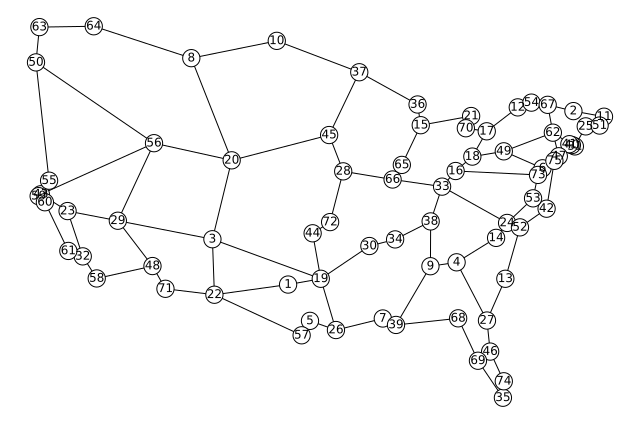

In [18]:
plt.figure(figsize=fig_size[topology])
pos = nx.get_node_attributes(graph, 'pos')
plt.axis('off')
nx.draw_networkx(graph, pos, node_color='white', edgecolors='black')
plt.tight_layout()
# plt.savefig(f'./results/{topology}.{export_format}') # you can set the format to pdf, png, eps, etc.
plt.show()
plt.close()

### Visualizing the placement

/home/carda/.conda/envs/python36-cplex/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


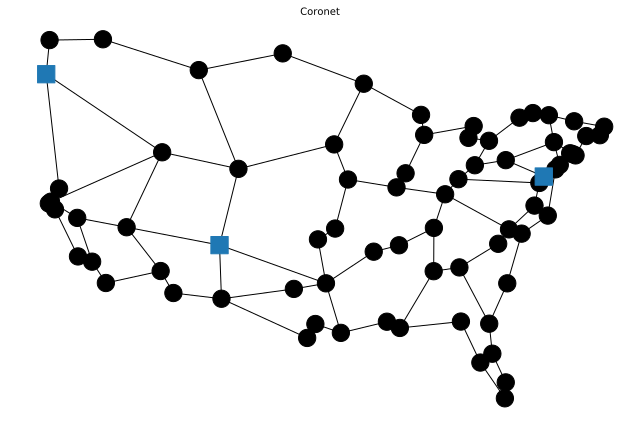

In [19]:
plt.figure(figsize=fig_size[topology])
pos = nx.get_node_attributes(graph, 'pos')
plt.axis('off')

plt.title('{}'.format(topology), fontsize=10)

# drawing only the network edges
nx.draw_networkx_edges(graph, pos)

nx.draw_networkx_nodes(graph, pos, nodelist=[q for q in graph.nodes() if variables_rpp[f'r_{q}'] == 0], node_color='black')
nx.draw_networkx_nodes(graph, pos, nodelist=[q for q in graph.nodes() if variables_rpp[f'r_{q}'] == 1], node_shape='s')

plt.tight_layout()
# plt.savefig(f'./results/{topology}_{budget}.{export_format}') # you can set the format to pdf, png, eps, etc.
plt.show()
plt.close()

## Critical link set detection (CLSD)

Function `clsd` returns the variable values of the solution for a given graph, placement solution and p.

done for p 2
found 2947 variables in the solution
done for p 3
found 2947 variables in the solution


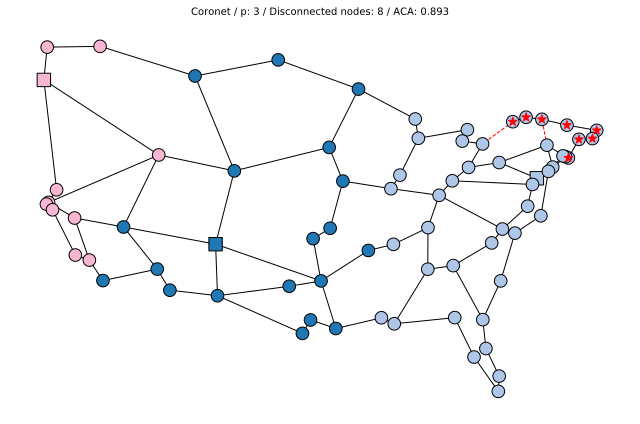

done for p 4
found 2947 variables in the solution
done for p 5
found 2947 variables in the solution
done for p 6
found 2947 variables in the solution


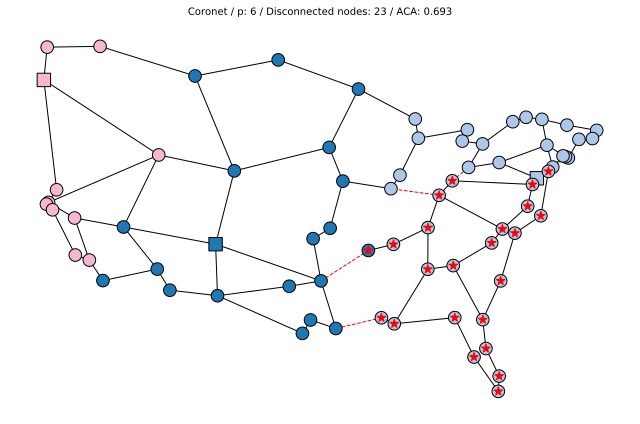

done for p 7
found 2947 variables in the solution
done for p 8
found 2947 variables in the solution
done for p 9
found 2947 variables in the solution


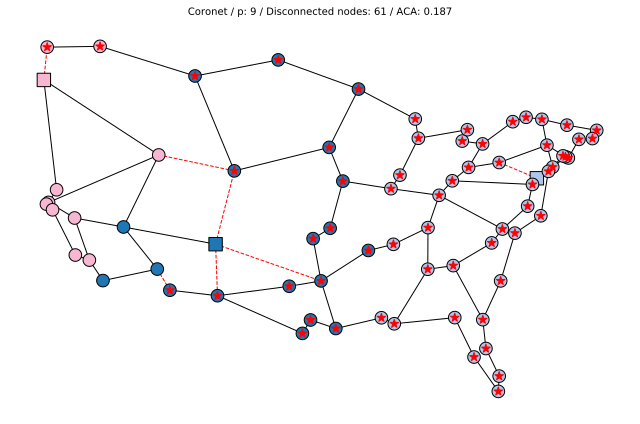

done for p 10
found 2947 variables in the solution
done for p 11
found 2947 variables in the solution
done for p 12
found 2947 variables in the solution


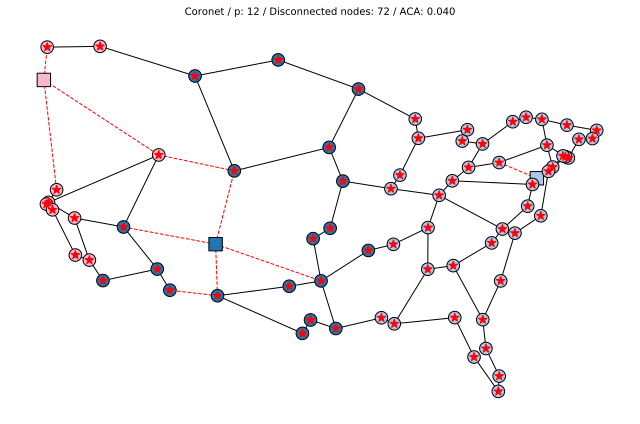

In [20]:
solutions_clsd = {}
aca_values = []
for p in range(pmin, pmax+1):
    
    solutions_clsd[p] = clsd(graph, variables_rpp, p)
    aca_value = (solutions_clsd[p]['sum_connected'] + budget) / graph.number_of_nodes()
    aca_values.append(aca_value)
    
    # only plots the graph representation for odd values of p
    if p % 3 != 0:
        continue
    
    plt.figure(figsize=fig_size[topology])
    pos = nx.get_node_attributes(graph, 'pos')
    plt.axis('off')

    plt.title('{} / p: {} / Disconnected nodes: {} / ACA: {:.3f}'.format(topology, 
                                                                  p, 
                                                                  int(graph.number_of_nodes() - budget - solutions_clsd[p]['sum_connected']),
                                                                  aca_value),
              fontsize=10)
    
    cmap = matplotlib.cm.get_cmap('tab20')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=graph.number_of_nodes())

    # drawing network edges
    normal_edges = []
    critical_edges = []
    for i,j in graph.edges():
        if solutions_clsd[p][f'x_{i}_{j}'] == 0: # not a critical edge
            normal_edges.append((i,j))
        else:
            critical_edges.append((i, j))
    nx.draw_networkx_edges(graph, pos, normal_edges)
    nx.draw_networkx_edges(graph, pos, critical_edges, edge_color='r', style='--')

    disconnected_nodes = {}
    dni = 1
    for q in graph.nodes(): # for all the nodes
        if variables_rpp[f'r_{q}'] == 0 and solutions_clsd[p][f'v_{q}'] == 0:
            disconnected_nodes[q] = str(dni)
            dni += 1
        if variables_rpp[f'r_{q}'] == 1: # if a node was selected as DC
            nodes_x = []
            nodes_y = []
            for s in graph.nodes(): # for all the nodes
                if q != s and variables_rpp[f'y_{q}_{s}'] == 1: # node s is using node q as DC
                    nodes_x.append(pos[s][0])
                    nodes_y.append(pos[s][1])
            plt.scatter(pos[q][0], pos[q][1], color=cmap(norm(float(q))), alpha=1., marker='s', linewidths=1., edgecolors='black', s=180.)
            plt.scatter(nodes_x, nodes_y, color=cmap(norm(float(q))), alpha=1., marker='o', linewidths=1., edgecolors='black', s=160.)
    
    plt.scatter([p[0] for key, p in pos.items() if key in disconnected_nodes],
                [p[1] for key, p in pos.items() if key in disconnected_nodes], marker='*', color='red', s=80)

    plt.tight_layout()
    plt.savefig(f'./results/{topology}_{budget}.{export_format}') # you can set the format to pdf, png, eps, etc.
    plt.show()
    plt.close()

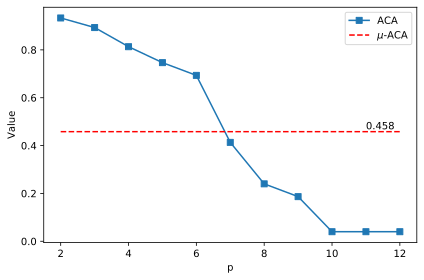

In [21]:
plt.figure()
plt.plot(range(pmin, pmax+1), aca_values, label='ACA', marker='s')
plt.plot(range(pmin, pmax+1), np.tile(np.mean(aca_values), len(aca_values)), label='$\mu$-ACA', linestyle='--', color='red')
plt.text(pmax-1, np.mean(aca_values)+.01, '{:.3f}'.format(np.mean(aca_values)))
plt.xlabel('p')
plt.ylabel('Value')
plt.legend(loc=1)
plt.tight_layout()
plt.show()